In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries
import pandas as pd
from google.colab import drive

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/NIDS/merged_dataset.csv')  # Use the full path

# Check basic stats
print("Dataset Information:")
print(df.info())
print("\n" + "-"*50 + "\n")

# Check distribution of labels (attack classes)
print("Label Distribution:")
print(df['label'].value_counts())
print("\n" + "-"*50 + "\n")

# Check for missing values
print("Missing Values per Column:")
print(df.isna().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import os
import warnings
warnings.filterwarnings('ignore')


# Step 2: Define Core Functions

def load_data(path):
    try:
        df = pd.read_csv(path)
        print(f" Data loaded successfully with shape: {df.shape}")
        return df
    except Exception as e:
        print(f" Error loading data: {e}")
        return None

def preprocess_data(df):
    # Example: basic cleaning (you can replace with your actual logic)
    df = df.dropna()
    df['attack_cat'] = df['attack_cat'].str.strip().str.lower()
    return df

def create_feature_pipeline(X):
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ])

    return preprocessor

#  Step 3: Main Execution - ONLY PATH CHANGES
if __name__ == "__main__":


    dataset_path = "/content/drive/MyDrive/NIDS/merged_dataset.csv"
    save_path = "/content/drive/MyDrive/NIDS/processed/"

    # Load and preprocess
    df = load_data(dataset_path)
    if df is None:
        exit()

    df = preprocess_data(df)

    # Verify class distribution
    print("\n Class standardization complete:")
    print(df['attack_cat'].value_counts())

    # Train-test split (stratified by attack category)
    X = df.drop(columns=['label', 'attack_cat'])
    y_multiclass = df['attack_cat']
    y_binary = df['label']

    X_train, X_test, y_mc_train, y_mc_test, y_bin_train, y_bin_test = train_test_split(
        X, y_multiclass, y_binary,
        test_size=0.3,
        random_state=42,
        stratify=y_multiclass
    )

    # Feature engineering
    preprocessor = create_feature_pipeline(X_train)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Label encoding for multiclass
    label_encoder = LabelEncoder()
    y_mc_train_encoded = label_encoder.fit_transform(y_mc_train)
    y_mc_test_encoded = label_encoder.transform(y_mc_test)

    # Save outputs (create directory if needed)
    os.makedirs(save_path, exist_ok=True)

    # Save processed data WITH RAW LABELS
    np.savez_compressed(
        save_path + "train_data.npz",
        X=X_train_processed,
        y_binary=y_bin_train.values,
        y_multiclass=y_mc_train_encoded,
        y_raw=y_mc_train.values  # Critical fix
    )
    np.savez_compressed(
        save_path + "test_data.npz",
        X=X_test_processed,
        y_binary=y_bin_test.values,
        y_multiclass=y_mc_test_encoded,
        y_raw=y_mc_test.values  # Critical fix
    )

    # Save preprocessing artifacts
    joblib.dump({
        'preprocessor': preprocessor,
        'label_encoder': label_encoder,
        'classes': label_encoder.classes_
    }, save_path + "preprocessor.joblib")

    # Final validation
    print("\n Final Class Distribution (Training Set):")
    print(y_mc_train.value_counts())
    print("\n Processing Completed!")
    print(f"Training shape: {X_train_processed.shape}")
    print(f"Test shape: {X_test_processed.shape}")
    print(f"Feature dimension: {X_train_processed.shape[1]}")

 Data loaded successfully with shape: (257673, 44)

 Class standardization complete:
attack_cat
normal            93000
generic           58871
exploits          44525
fuzzers           24246
dos               16353
reconnaissance    13987
analysis           2677
backdoor           2329
shellcode          1511
worms               174
Name: count, dtype: int64

 Final Class Distribution (Training Set):
attack_cat
normal            65100
generic           41210
exploits          31167
fuzzers           16972
dos               11447
reconnaissance     9791
analysis           1874
backdoor           1630
shellcode          1058
worms               122
Name: count, dtype: int64

 Processing Completed!
Training shape: (180371, 194)
Test shape: (77302, 194)
Feature dimension: 194


In [ ]:
# SUPPRESS ALL WARNINGS
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['LOKY_CONTROL'] = '1'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Suppress CUDA warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

# FINAL CLASS IMBALANCE SOLUTION
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import joblib
from scipy.sparse import csr_matrix

def handle_class_imbalance():
    # 0. LOAD AND FIX SPARSE MATRIX
    train_data = np.load('/content/drive/MyDrive/NIDS/processed/train_data.npz', allow_pickle=True)

    # Fix sparse matrix correctly
    X_train = train_data['X'].item() if isinstance(train_data['X'][()], csr_matrix) else train_data['X']
    y_train = train_data['y_multiclass']

    # Convert to dense array
    if isinstance(X_train, csr_matrix):
        X_train = X_train.toarray()

    # 1. CORRECTED RESAMPLING
    def balanced_resampling(X, y):
        """Targeted resampling for critical minority classes"""
        classes, counts = np.unique(y, return_counts=True)
        print("Original distribution (raw):", dict(zip(classes, counts)))

        sampling_strategy = {
            8: 1500,  # Shellcode
            9: 500    # Worms
        }

        sm = SMOTE(
            sampling_strategy=sampling_strategy,
            k_neighbors=2,
            random_state=42
        )

        X_res, y_res = sm.fit_resample(X, y)
        return X_res, y_res

    # Apply resampling
    X_resampled, y_resampled = balanced_resampling(X_train, y_train)

    # 2. SAFE CLASS WEIGHTS
    def calculate_class_weights(y):
        classes, counts = np.unique(y, return_counts=True)
        median = np.median(counts)
        weights = np.sqrt(median / (counts + 1e-5))
        weights = np.clip(weights, 0.5, 5.0)
        return {cls: float(weight) for cls, weight in zip(classes, weights)}

    class_weights = calculate_class_weights(y_resampled)

    # 3. DATA PREPARATION
    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_resampled)

    # Save processed data
    save_path = '/content/drive/MyDrive/NIDS/processed/'
    np.savez_compressed(
        save_path + 'final_train.npz',
        X=X_resampled,
        y=to_categorical(y_train_enc),
        y_raw=y_resampled
    )
    joblib.dump(label_encoder, save_path + 'label_encoder.joblib')

    #  4. VALIDATION OUTPUT
    print(f"\nFinal Training Shape: {X_resampled.shape}")
    return y_train, y_resampled, class_weights

# RUN MAIN IMBALANCE HANDLER
y_train, y_resampled, class_weights = handle_class_imbalance()

# CLASS NAME MAPPING
class_names = {
    0: 'Normal',
    1: 'Analysis',
    2: 'Backdoor',
    3: 'DoS',
    4: 'Exploits',
    5: 'Fuzzers',
    6: 'Generic',
    7: 'Reconnaissance',
    8: 'Shellcode',
    9: 'Worms'
}

# ORIGINAL DISTRIBUTION (MAPPED)
print("\n ORIGINAL CLASS DISTRIBUTION:")
original_counts = dict(zip(*np.unique(y_train, return_counts=True)))
for k in sorted(original_counts):
    print(f"  {class_names[k]:<15} : {original_counts[k]}")

# RESAMPLED DISTRIBUTION (MAPPED)
print("\n RESAMPLED CLASS DISTRIBUTION:")
resampled_counts = dict(zip(*np.unique(y_resampled, return_counts=True)))
for k in sorted(resampled_counts):
    print(f"  {class_names[k]:<15} : {resampled_counts[k]}")

# CLASS WEIGHTS (MAPPED)
print("\n  CLASS WEIGHTS:")
for k in sorted(class_weights):
    print(f"  {class_names[k]:<15} : {class_weights[k]:.4f}")


Original distribution (raw): {np.int64(0): np.int64(1874), np.int64(1): np.int64(1630), np.int64(2): np.int64(11447), np.int64(3): np.int64(31167), np.int64(4): np.int64(16972), np.int64(5): np.int64(41210), np.int64(6): np.int64(65100), np.int64(7): np.int64(9791), np.int64(8): np.int64(1058), np.int64(9): np.int64(122)}

Final Training Shape: (181191, 194)

 ORIGINAL CLASS DISTRIBUTION:
  Normal          : 1874
  Analysis        : 1630
  Backdoor        : 11447
  DoS             : 31167
  Exploits        : 16972
  Fuzzers         : 41210
  Generic         : 65100
  Reconnaissance  : 9791
  Shellcode       : 1058
  Worms           : 122

 RESAMPLED CLASS DISTRIBUTION:
  Normal          : 1874
  Analysis        : 1630
  Backdoor        : 11447
  DoS             : 31167
  Exploits        : 16972
  Fuzzers         : 41210
  Generic         : 65100
  Reconnaissance  : 9791
  Shellcode       : 1500
  Worms           : 500

  CLASS WEIGHTS:
  Normal          : 2.3804
  Analysis        : 2.5

Resampling classes: {'Worms': 261}
Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 30s 145ms/step - accuracy: 0.6345 - f1_score: 0.4881 - loss: 0.4618 - val_accuracy: 0.0141 - val_f1_score: 0.0000e+00 - val_loss: 1.7149 - learning_rate: 0.0010
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.7589 - f1_score: 0.7210 - loss: 0.2655 - val_accuracy: 0.2265 - val_f1_score: 0.0000e+00 - val_loss: 1.8571 - learning_rate: 0.0010
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.7805 - f1_score: 0.7565 - loss: 0.2352 - val_accuracy: 0.4362 - val_f1_score: 0.3787 - val_loss: 1.0475 - learning_rate: 0.0010
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.7918 - f1_score: 0.7740 - loss: 0.2225 - val_accuracy: 0.7295 - val_f1_score: 0.7131 - val_loss: 0.2917 - learning_rate: 0.0010
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 40s 144ms/step - accuracy: 0.7996 - f1_score: 0.7843 - loss: 0.2077 - val_accuracy: 0.7929 - val_f1_score: 0.7787 - val_loss: 0.2

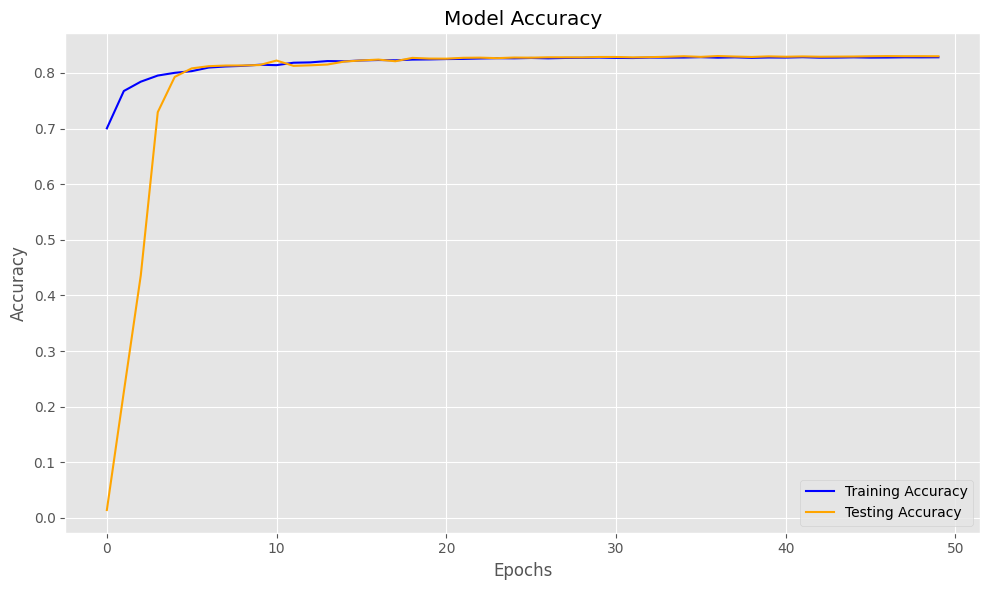

1612/1612 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step

Final Classification Report:
                precision    recall  f1-score   support

      Analysis       0.29      0.25      0.27       535
      Backdoor       0.20      0.24      0.21       466
           DoS       0.36      0.64      0.46      3271
      Exploits       0.78      0.59      0.67      8905
       Fuzzers       0.78      0.73      0.75      4849
       Generic       1.00      0.98      0.99     11774
        Normal       0.96      0.95      0.96     18600
Reconnaissance       0.79      0.80      0.79      2798
     Shellcode       0.39      0.78      0.52       302
         Worms       0.18      0.73      0.28        60

      accuracy                           0.83     51560
     macro avg       0.57      0.67      0.59     51560
  weighted avg       0.86      0.83      0.84     51560



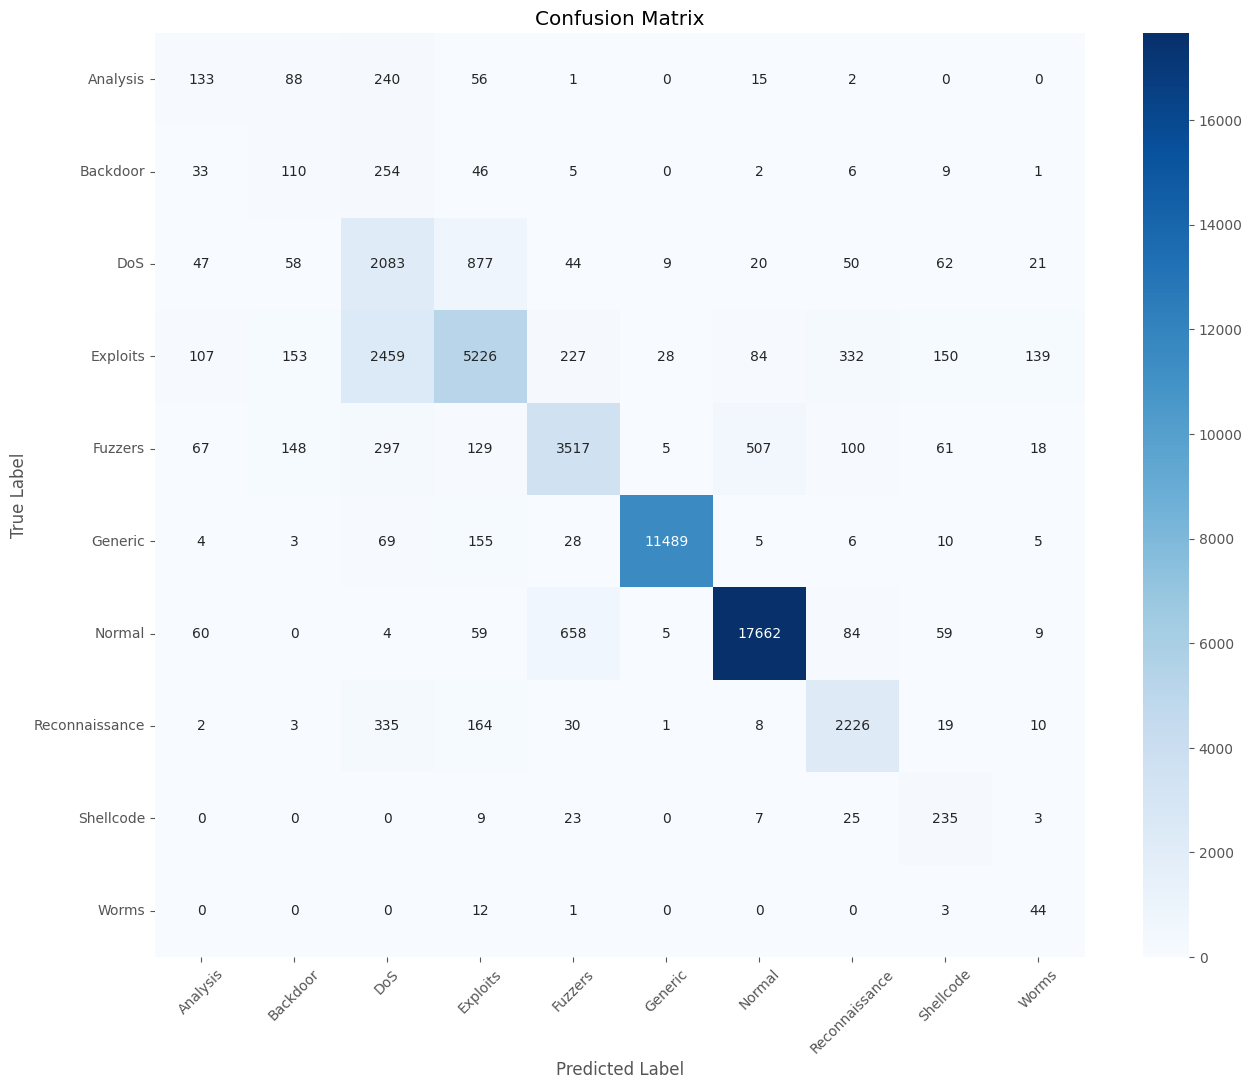

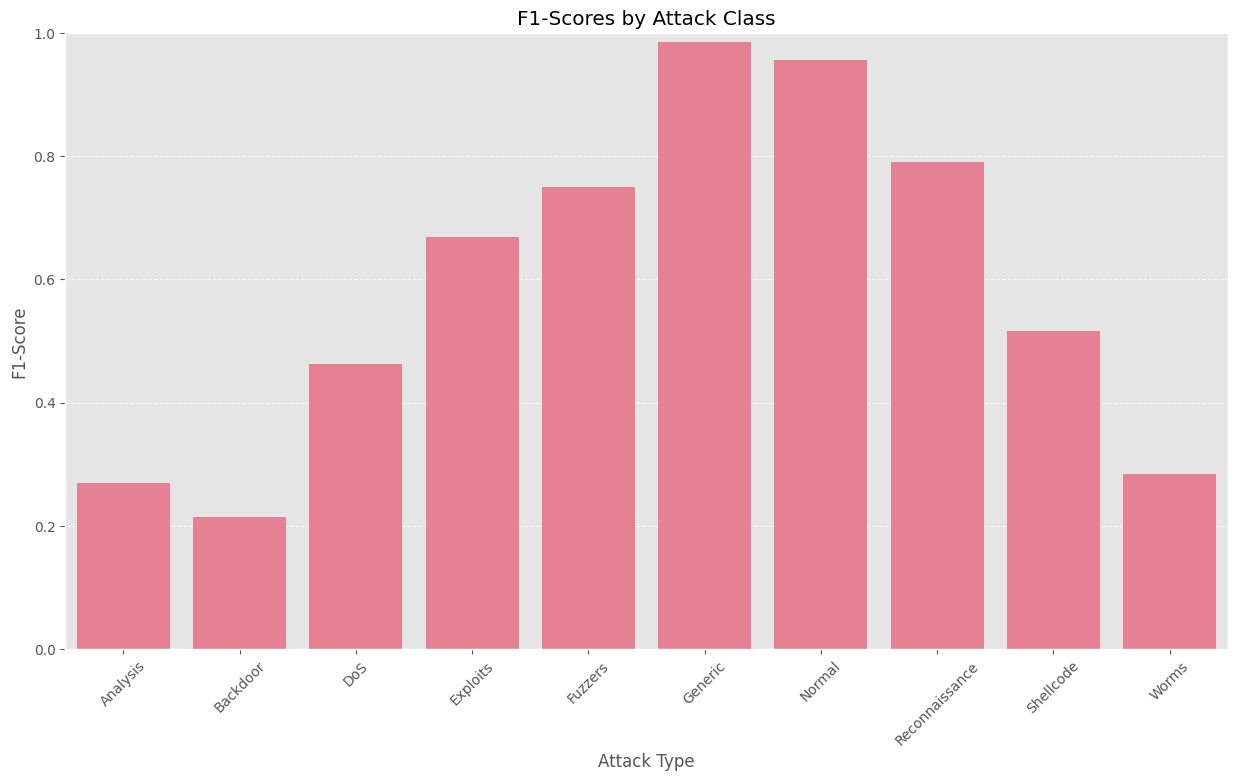

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, MaxPooling1D, Attention, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.losses import CategoricalFocalCrossentropy

plt.style.use('ggplot')
sns.set_palette("husl")

class EnhancedF1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.smoothing_factor = 0.01

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return (2 * p * r) / (p + r + self.smoothing_factor)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

def calculate_class_weights(y):
    class_counts = np.bincount(y)
    median = np.median(class_counts[class_counts > 0])
    return {cls: float(np.sqrt(median / (count + 1e-5))) for cls, count in enumerate(class_counts)}

def build_hybrid_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stacked CNN Branch
    x = Conv1D(128, 5, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    # LSTM Branch with Attention
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    attention = Attention()([lstm_out, lstm_out])
    x = concatenate([lstm_out, attention])
    x = Bidirectional(LSTM(32))(x)

    # Classification Head
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def plot_metrics(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'])

    plt.figure(figsize=(15, 8))
    sns.barplot(x=metrics_df.index, y=metrics_df['f1-score'])
    plt.title('F1-Scores by Attack Class')
    plt.xlabel('Attack Type')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_accuracy_graph(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    df = pd.read_csv('/content/drive/MyDrive/NIDS/merged_dataset.csv')

    categorical_features = ['proto', 'service', 'state']
    numerical_features = [col for col in df.columns
                          if col not in categorical_features + ['label', 'attack_cat']]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    df['packet_size_ratio'] = (df['sbytes'] + 1) / (df['dbytes'] + 1)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    le = LabelEncoder()
    df['attack_cat'] = np.where(df['label'] == 0, 'Normal', df['attack_cat'])
    y = le.fit_transform(df['attack_cat'])
    X = preprocessor.fit_transform(df.drop(columns=['label', 'attack_cat'])).toarray()

    class_counts = np.bincount(y)
    sampling_strategy = {}
    for cls_idx, count in enumerate(class_counts):
        if 0 < count < 1000:
            target = int(count * 1.5)
            if target > count:
                sampling_strategy[cls_idx] = target

    if sampling_strategy:
        print(f"Resampling classes: { {le.inverse_transform([k])[0]: v for k,v in sampling_strategy.items()} }")
        min_count = min([class_counts[k] for k in sampling_strategy.keys()])
        sampler = ADASYN(
            sampling_strategy=sampling_strategy,
            n_neighbors=min(5, max(1, min_count - 1)),
            random_state=42
        )
        X_res, y_res = sampler.fit_resample(X, y)
    else:
        X_res, y_res = X, y

    if X_res.ndim == 1:
        X_res = X_res.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res,
        test_size=0.2,
        stratify=y_res,
        random_state=42
    )

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = build_hybrid_model(X_train.shape[1:], len(le.classes_))
    model.compile(
        optimizer=Adam(0.001),
        loss=CategoricalFocalCrossentropy(gamma=2.0, alpha=0.75),
        metrics=['accuracy', EnhancedF1Score()]
    )

    history = model.fit(
        X_train, to_categorical(y_train),
        epochs=50,
        batch_size=1024,
        validation_split=0.15,
        class_weight=calculate_class_weights(y_train),
        callbacks=[
            EarlyStopping(patience=10, monitor='val_f1_score', mode='max', restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=5),
            ModelCheckpoint('/content/drive/MyDrive/NIDS/processed/best_model.h5', save_best_only=True)
        ],
        verbose=1
    )

    # Plot Accuracy Graph
    plot_accuracy_graph(history)

    model.load_weights('/content/drive/MyDrive/NIDS/processed/best_model.h5')
    y_pred = model.predict(X_test).argmax(axis=1)

    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    plot_confusion_matrix(y_test, y_pred, le.classes_)
    plot_metrics(y_test, y_pred, le.classes_)

if __name__ == "__main__":
    main()


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.6 MB/s eta 0:00:00


Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 158s 331ms/step - accuracy: 0.8610 - f1_score: 0.8567 - loss: 0.2884 - val_accuracy: 0.8079 - val_f1_score: 0.7605 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 191s 316ms/step - accuracy: 0.9441 - f1_score: 0.9391 - loss: 0.1311 - val_accuracy: 0.9600 - val_f1_score: 0.9552 - val_loss: 0.0927 - learning_rate: 0.0010
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 142s 317ms/step - accuracy: 0.9539 - f1_score: 0.9488 - loss: 0.1080 - val_accuracy: 0.9622 - val_f1_score: 0.9572 - val_loss: 0.0865 - learning_rate: 0.0010
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 139s 310ms/step - accuracy: 0.9588 - f1_score: 0.9537 - loss: 0.0980 - val_accuracy: 0.9652 - val_f1_score: 0.9599 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 137s 313ms/step - accuracy: 0.9601 - f1_score: 0.9549 - loss: 0.0956 - val_accuracy: 0.9655 - val_f1_score: 0.9604 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 6/20

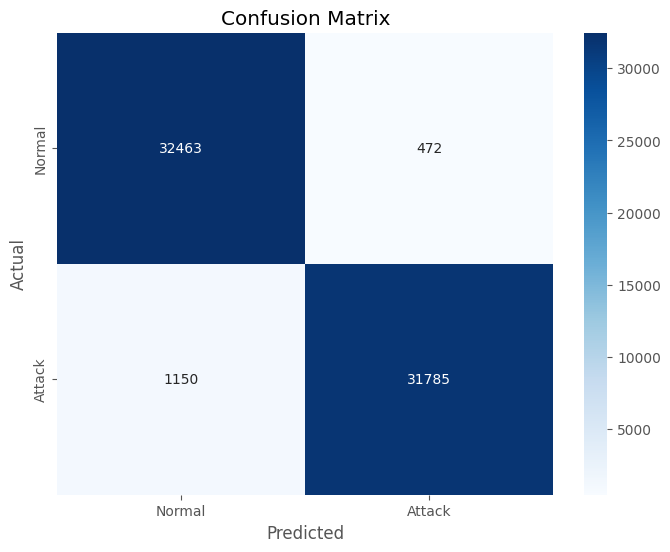

<Figure size 1000x600 with 0 Axes>

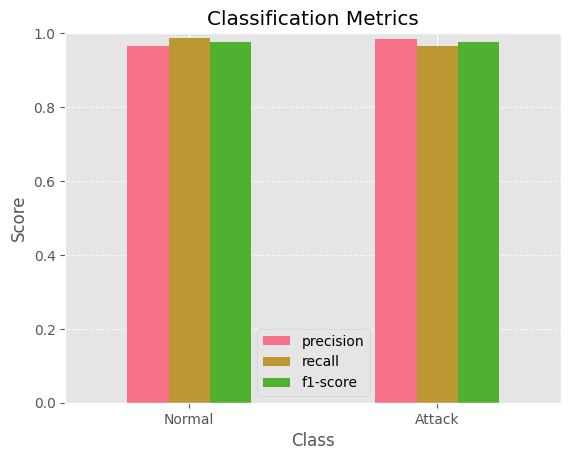

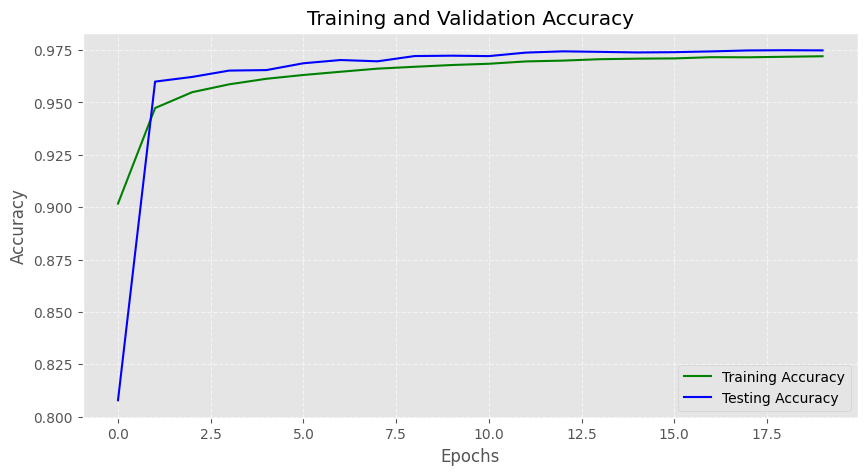

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, LSTM, Bidirectional, Dense, Dropout,
                                     BatchNormalization, MaxPooling1D, Attention, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Visualization setup
plt.style.use('ggplot')
sns.set_palette("husl")

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.smoothing_factor = 0.01

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + self.smoothing_factor))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

def build_binary_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN Architecture
    x = Conv1D(128, 5, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    # LSTM with Attention
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    attention = Attention()([lstm_out, lstm_out])
    x = concatenate([lstm_out, attention])
    x = Bidirectional(LSTM(32, recurrent_dropout=0.2))(x)
    x = Dropout(0.4)(x)

    # Classification Head
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)

def calculate_class_weights(y):
    class_counts = np.bincount(y)
    total = sum(class_counts)
    return {0: total/(2*class_counts[0]), 1: total/(2*class_counts[1])}

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['Normal', 'Attack'], output_dict=True)
    metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

    plt.figure(figsize=(10,6))
    metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
    plt.title('Classification Metrics')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy', color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def main():
    df = pd.read_csv('/content/drive/MyDrive/NIDS/merged_dataset.csv')

    # Feature engineering
    df['packet_size_ratio'] = (df['sbytes'] + 1) / (df['dbytes'] + 1)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    # Preprocessing
    categorical_features = ['proto', 'service', 'state']
    numerical_features = [col for col in df.columns
                         if col not in categorical_features + ['label', 'attack_cat']]

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # Convert sparse matrix to dense array
    X = preprocessor.fit_transform(df.drop(columns=['label', 'attack_cat'])).toarray()
    y = df['label'].values

    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res,
        test_size=0.2,
        stratify=y_res,
        random_state=42
    )

    # Reshape for Conv1D
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build and compile model
    model = build_binary_model(X_train.shape[1:])
    model.compile(
        optimizer=Adam(0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', F1Score()],
    )

    # Class weights
    class_weights = calculate_class_weights(y_train)

    # Training
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=512,  # Reduced from 1024 for better memory usage
        validation_split=0.15,
        class_weight=class_weights,
        callbacks=[
            EarlyStopping(patience=10, monitor='val_f1_score', mode='max',
                         restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=5),
            ModelCheckpoint('/content/drive/MyDrive/NIDS/processed/best_binary_model.keras',
                           save_best_only=True)
        ],
        verbose=1
    )

    # Evaluation
    model = tf.keras.models.load_model('/content/drive/MyDrive/NIDS/processed/best_binary_model.keras',
                                      custom_objects={'F1Score': F1Score})
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

    # Visualizations
    plot_confusion_matrix(y_test, y_pred)
    plot_metrics(y_test, y_pred)
    plot_accuracy(history)

if __name__ == "__main__":
    main()

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step

📄 Classification Report:
                precision    recall  f1-score   support

      Analysis     0.2936    0.2486    0.2692       535
      Backdoor     0.1954    0.2361    0.2138       466
           DoS     0.3628    0.6368    0.4623      3271
      Exploits     0.7766    0.5869    0.6685      8905
       Fuzzers     0.7757    0.7253    0.7497      4849
       Generic     0.9958    0.9758    0.9857     11774
        Normal     0.9646    0.9496    0.9570     18600
Reconnaissance     0.7863    0.7956    0.7909      2798
     Shellcode     0.3871    0.7781    0.5171       302
         Worms     0.1043    0.6857    0.1811        35

      accuracy                         0.8287     51535
     macro avg     0.5642    0.6618    0.5795     51535
  weighted avg     0.8557    0.8287    0.8368     51535



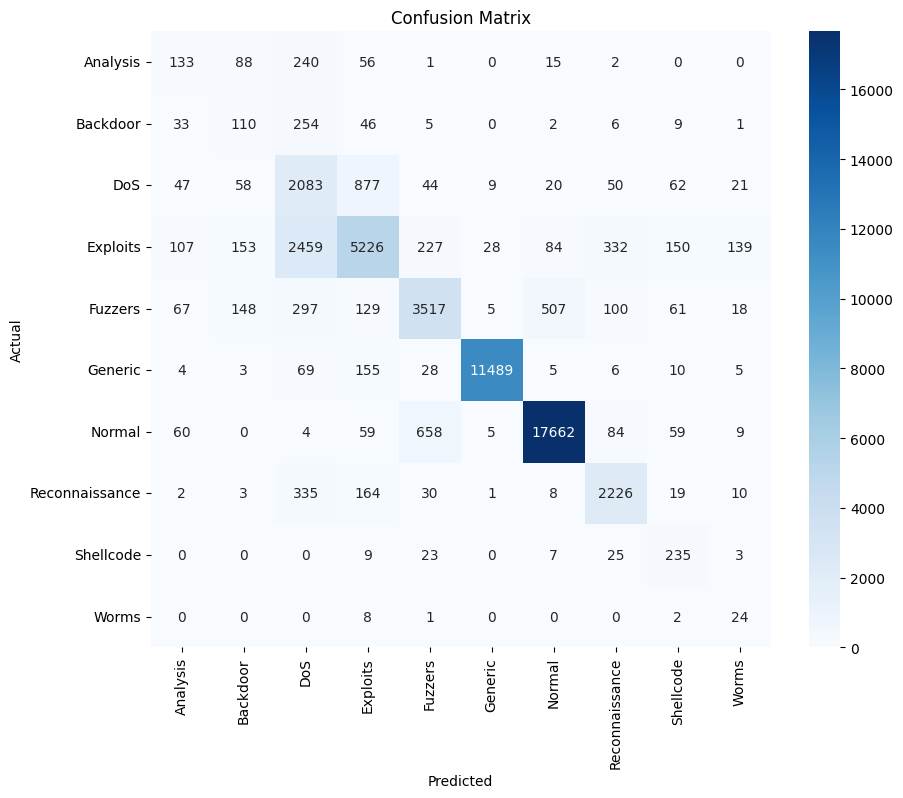


📊 Model Accuracy: 0.8287


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.smoothing_factor = 0.01

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + self.smoothing_factor))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def main():
    # Load data
    df = pd.read_csv('/content/drive/MyDrive/NIDS/merged_dataset.csv', engine='c', low_memory=True)

    # Feature configuration
    categorical_features = ['proto', 'service', 'state']
    numerical_features = [col for col in df.columns
                         if col not in categorical_features + ['label', 'attack_cat']]

    # Preprocessing: Apply OneHotEncoder and StandardScaler to the data
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    X = preprocessor.fit_transform(df.drop(columns=['label', 'attack_cat']))

    # Target processing for binary or multiclass
    multiclass_mode = df['attack_cat'].nunique() > 2
    le = LabelEncoder()
    y = le.fit_transform(df['attack_cat']) if multiclass_mode else df['label'].values
    class_names = le.classes_ if multiclass_mode else ['Normal', 'Attack']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        tf.keras.utils.to_categorical(y) if multiclass_mode else y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    # Load the pre-trained model
    model_path = '/content/drive/MyDrive/NIDS/processed/best_model.h5'
    model = tf.keras.models.load_model(model_path, custom_objects={'F1Score': F1Score})

    # Batch prediction for speed
    y_pred = model.predict(X_test, batch_size=2048)
    y_pred = y_pred.argmax(1) if multiclass_mode else (y_pred > 0.5).astype(int)
    y_true = y_test.argmax(1) if multiclass_mode else y_test

    # Results
    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    plot_confusion_matrix(y_true, y_pred, class_names)

    # Model accuracy
    accuracy = np.mean(y_pred == y_true)
    print("\n📊 Model Accuracy: {:.4f}".format(accuracy))

if __name__ == '__main__':
    main()


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step

📄 Classification Report:
              precision    recall  f1-score   support

      Normal     0.9676    0.9615    0.9645     18600
      Attack     0.9783    0.9818    0.9801     32935

    accuracy                         0.9745     51535
   macro avg     0.9730    0.9717    0.9723     51535
weighted avg     0.9745    0.9745    0.9745     51535



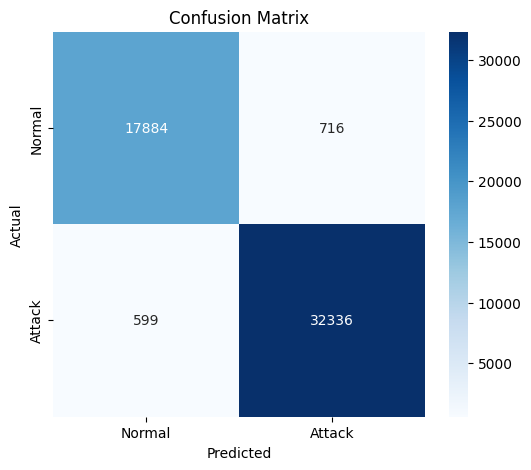


📊 Model Accuracy: 0.9745


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.smoothing_factor = 0.01

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + self.smoothing_factor))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Main pipeline
def main():
    # Load dataset
    df = pd.read_csv('/content/drive/MyDrive/NIDS/merged_dataset.csv', engine='c', low_memory=True)

    # Define categorical and numerical features
    categorical_features = ['proto', 'service', 'state']
    numerical_features = [col for col in df.columns if col not in categorical_features + ['label', 'attack_cat']]

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    X = preprocessor.fit_transform(df.drop(columns=['label', 'attack_cat']))
    y = df['label'].values  # Binary target (0: Normal, 1: Attack)
    class_names = ['Normal', 'Attack']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    # Load pre-trained binary model
    model = tf.keras.models.load_model(
        '/content/drive/MyDrive/NIDS/processed/best_binary_model.h5',
        custom_objects={'F1Score': F1Score}
    )

    # Predict
    y_pred_proba = model.predict(X_test, batch_size=2048)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Results
    print("\n📄 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    plot_confusion_matrix(y_test, y_pred, class_names)

    # Accuracy
    accuracy = np.mean(y_pred == y_test)
    print("\n📊 Model Accuracy: {:.4f}".format(accuracy))

if __name__ == '__main__':
    main()
